# Tutorial - Part 1

This is the first part of the QuickSR tutorial. This section provides the minimal steps required to perform symbolic regression on a synthetic dataset.

**Dependencies**


First of all, we need to import QuickSR and other dependencies

In [1]:
from quicksr import *

import numpy as np
import matplotlib.pyplot as plt

**Dataset**

For simplicity, we'll use a synthetic, single-dimensional dataset, for which we already know the exact algebraic formula:

In [2]:
X = np.linspace(-5, 5, 25)
y = 2.5382 * np.cos(X)*X + X*X - 0.5

Here's how the dataset looks like:

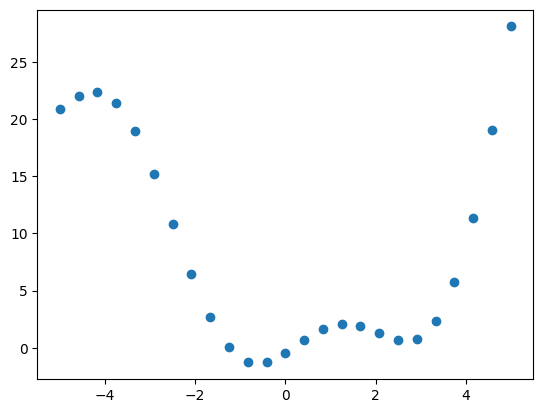

In [3]:
plt.figure()
plt.scatter(X, y)
plt.show()

Now, our goal is to fit a curve to these 25 points. If we are lucky, we expect to find exact the expression that we have used to generate the dataset.

**Configuration**

Let's start by defining the constants and "hyperparameters" of symbolic regression. First, the constant NVARS denotes the number of features present in our dataset. Since we only have a single feature (the x-axis values), we set NVARS to one.

In [4]:
NVARS = 1

An important hyperparameter we need to determine is the population size. This is the number of candidate expressions that will exist at every generation. For now, let's set it to an arbitrary value.

In [5]:
NPOPULATION = 11200

QuickSR partitions the population into equal-size groups called islands. Each island is assigned to its own CPU core. The associated GPU kernels are also executed on the island's own stream. Therefore, it is reasonable to set the number of islands to the maximum level of task parallelism supported by the machine. Since this notebook was executed on a 28-core CPU, we use 28 here. You can adjust this value according to your own environment. With this choice, we have 11200 / 28 = 400 expressions per island.

In [6]:
NISLANDS = 28

In QuickSR we have two types of constants in candidate expressions:

1. Regular constants 
2. Trainable constants (also referred to as trainable weights or trainable parameters)

Regular constants arise naturally from algebraic operations. For example, the constant $2$ can arise from the simplification of the expression $(x + x) / x$.

Trainable constants, on the other hand, are explicitly inserted into candidate expressions. Initially, these have random values. Before an expression is evaluated for loss, these constants are learned using gradient descent and backpropagation. 
For example, the constants $w_{0}$ and $w_{1}$ in the expression $w_{0} + x \times w_{1}$ are trainable constants.

To determine the maximum number of distinct trainable constants, we use NWEIGHTS. For now, let's set it to two.

In [7]:
NWEIGHTS = 2

**The Model**

In this step, we create a symbolic regression model using the aforemention configuration parameters. In addition, we limit the depth of candidate expressions in the initial population to one, meaning that the initial population can only consists of variables (which is just the single feature x) and constants (e.g., 2.3). Anything else will be generated during later genetic operations.

It is important to note that we can actually configure a lot more things here, but we will continue with the default choices in this tutorial.

In [8]:
model = SymbolicRegressionModel(NVARS, NWEIGHTS, NPOPULATION, NISLANDS, 
    initialization=GrowInitialization(init_depth=1))

**Training**

It is finally the time to train the model and see what expression it suggests. However, before continuing, we need to determine two more hyperparameters.

1. ngenerations
2. nsupergenerations

In QuickSR, every island evolves in isolation from other islands for $ngenerations$ many iterations. At the end of the isolation step, the best solution found by $island_{(i)}$ replaces the worst solution found by $island_{(i+1)}$, which is called the migration step. The entirety of this two-step process is repeated for $nsupergenerations$ times. Thus, the total number of iterations is given by $ngenerations \times nsupergenerations$.

Let's set ngenerations to 5 and nsupergenerations to 4, yielding a total of 20 iterations. We will also use 500 epochs in gradient descent to fit the trainable constants. This can take some time.

In [9]:
solution, _, _ = model.fit(X, y, ngenerations=5, nsupergenerations=4, nepochs=500)

Island 12 Best solution: (x0) * ((x0) + (w0=-0.937014)) Loss: 13.4559
Island 0 Best solution: ((x0) - (w1=0.931526)) * (x0) Loss: 13.4561
Island 27 Best solution: ((x0) + (cos(x0))) * ((w0=-0.531155) + (x0)) Loss: 5.33177
Island 21 Best solution: ((x0) + (w1=-0.936625)) * (x0) Loss: 13.4559
Island 8 Best solution: ((w0=-0.934931) + (x0)) * (x0) Loss: 13.4559
Island 7 Best solution: (x0) * ((x0) + (w1=-0.936529)) Loss: 13.4559
Island 14 Best solution: (sin(x0)) + (((x0) + (w0=-0.861429)) * (x0)) Loss: 14.547
Island 4 Best solution: ((x0) * (x0)) - (x0) Loss: 13.4921
Island 16 Best solution: ((x0) * (x0)) - (((x0) - (w0=-0.124843)) + (w1=0.520710)) Loss: 13.2633
Island 2 Best solution: ((x0) + (w0=-0.935558)) * (x0) Loss: 13.4559
Island 18 Best solution: relu((x0) * (((x0) - (w0=0.888435)) - (w1=0.056183))) Loss: 13.4309
Island 13 Best solution: ((x0) - (w0=0.925074)) * (x0) Loss: 13.4571
Island 3 Best solution: (x0) * ((relu((x0) + (x0))) + (w0=-4.781519)) Loss: 11.2703
Island 22 Best s

**Inference**

It's time to print the best solution.

In [10]:
solution

((((x0) * (x0)) - (w0=0.250004)) - (w0=0.250004)) - (((x0) * (cos(x0))) / (w1=-0.393980))

We can also display what the model prediction looks like, and compare it with the original dataset

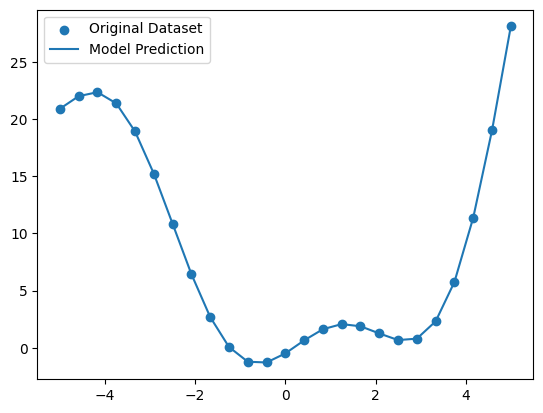

In [12]:
y_original = y
y_predicted = model.predict(X)

plt.figure()
plt.scatter(X, y_original, label='Original Dataset')
plt.plot(X, y_predicted, label='Model Prediction')
plt.legend()
plt.show()

We have obtained a nearly perfect fit. It has also discovered the terms $x*x$ and $x*cos(x)$ in the original expression that was used to generate the dataset.